(explainer_topic_model)=
hSBM topic modelling
==================

# Topic Modelling with hSBM: Community Detection in a Topic Model Context

In this section we introduce part of our text analysis, namely the part which pertains to our topic modelling approach. Topic models are mainly used to cluster a collection of documents into different so-called 'topics'. In oue analysis, we choose relevant topics, extract their topic distributions and visualize the words for each topic to demonstrate how and in which areas the different disciplines tend to interact on Wikipedia. 

In [141]:
# Import relevant modules
import os
import joblib
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
import networkx as nx
import pandas as pd
import json
from IPython.display import display, Image, set_matplotlib_formats
import ast
from matplotlib import rc
plt.style.use('science')
set_matplotlib_formats('svg')
rc("text", usetex=False)

In [3]:
# load data
path = '/Users/emiliemunchgregersen/Downloads'
os.chdir(path)

# wikipedia data
df = pd.read_csv('wiki_df_new.csv.gz', compression = 'gzip')
df = df.drop('Unnamed: 0', axis =1)
df.tokens = df.tokens.apply(eval)
new_names = list(zip(df.parent+ '-' + df.title))
new_names = [tuple[0] for index, tuple in enumerate(new_names)]

# hSBM data
topic_dist_df = pd.read_csv('topic_dist_df.csv')
topic_dist_df = topic_dist_df.drop('Unnamed: 0', axis = 1)
f = open('topics_l1.json')
topics_l1 = json.load(f) # topics at level 1 returning 20 most probable words
topics_l1 = {int(k):v for k,v in topics_l1.items()}

# network data 
word_nx = pd.read_csv('word_bipartite_df.csv')
word_nx = word_nx.drop('Unnamed: 0', axis = 1)
bipart_nx = pd.read_csv('bipartite_df.csv')
bipart_nx = bipart_nx.drop('Unnamed: 0', axis = 1)

### hSBM Topic Modelling
Inspired by the approach set forth by [Gerlach et al. 2018](https://www.science.org/doi/10.1126/sciadv.aaq1360), we show the hierarchical clustering of documents and words from our wikipedia dataset for all six scientific disciplines using a **hierarchical Stochastic Block Model** (hSBM). We only consider words that appear more than ten times in the text corpus and end up with 4810 articles or in our case, nodes. As opposed to other popular topic models such as LDA, we do not need to specify number of groups, levels or topics beforehand, since hSBM automatically detects these parameters. The model is inspired by community detection in networks and creates a bipartite-like network of words and documents. It splits the network into groups on different hierarchical levels organized as a tree. On each level, the hSBM clusters the documents and words in varying group sizes.

We have fed the model with data consisting of preprocessed tokens from each Wikipedia article where we remove infrequent tokens with a threshold at minimum 10 occurences per token. We are able to extract the documents from the model using the document number which corresponds to the index from our dataframe. We have merged the title of each article with the discipline from which it originates i.e. 'Voter Turnout' becomes 'political_science-voter_turnout, which we need for the forthcoming analysis. 


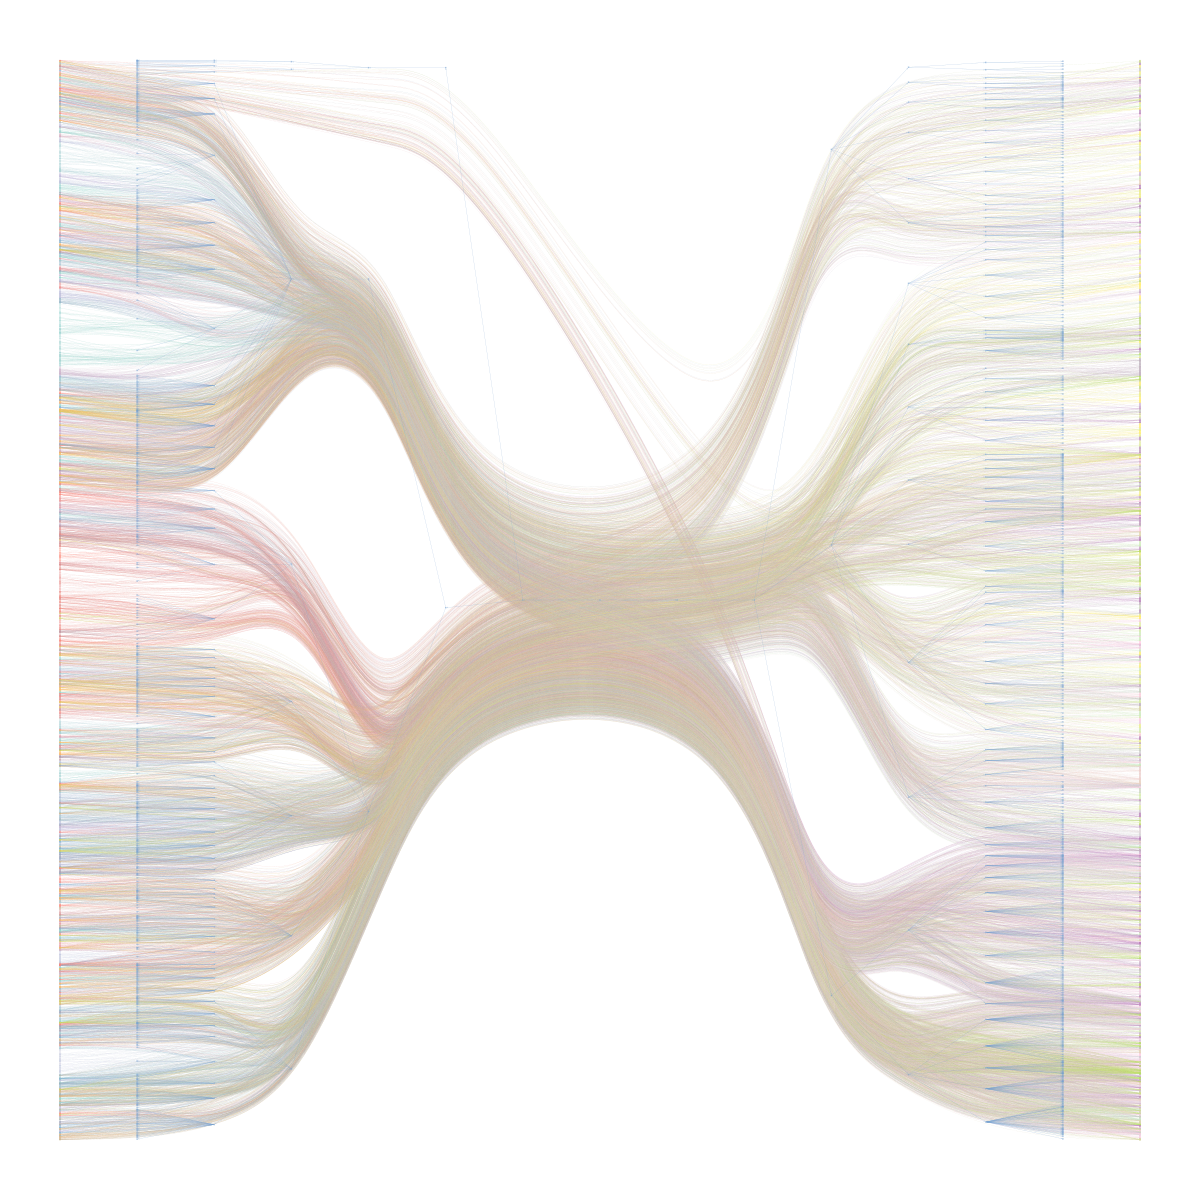

In [171]:
# plot of the model's hierarchical layers 
Image(filename = '/Users/emiliemunchgregersen/Downloads/hSBM.png', width = 50, height = 20)

The above image shows the structure of the model. On the left side, we have the documents and on the right side, we see the words. Compared to Gerlach et al.'s visualization (see link), we are not able to detect the different disciplines from this image, however we do find the division on the document-ax interesting as it seems to divide the divide the documents into two overall sections. 

We have experimented with extracting topics at different levels of the model (our model has 7 levels). Generally, we find that the topics at level 1 are the most cohesive and specific which is useful for our analysis. We specify that the model should return the 20 most probable words per topic (remember the model itself chooses number of topics). The model generates 76 topics on level 1 which span from very method-related to more theme or topic-specific such as 'socialism' or 'US politics'. On level 2, we find 15 topics which are more discipline-related and broader. The lower the level, the less semantically cohesive the topics. We choose and name 10 topics for our content analysis: 

In [157]:
# the 10 topics from level 1 of our model
chosen_topics = {'administrative_science':topics_l1[7], 'market_economy':topics_l1[18], 'museum_anthropology':topics_l1[23],
  'cognitive_psychology':topics_l1[25], 'academia':topics_l1[30], 'statistical_methods':topics_l1[32], 
   'socialism':topics_l1[43], 'labour_economics':topics_l1[53], 'class_racialization':topics_l1[68], 
  'US_politics_SoMe':topics_l1[75]}

# we create a pandas dataframe for our topics and topic words
topic_names = list(chosen_topics.keys())

topic_df = pd.DataFrame(index = topic_names)
topic_df['topics'] =   list(chosen_topics.values())

The topics are chosen based on word clusters we find semantically meaningful and interesting for our query at hand - we choose some we believe to be purely discipline-specific and some which we believe to capture some overlap between disciplines. Our analysis will therefore touch upon patterns and tendencies rather than generalize across our entire dataset. We choose to visualize the word-topics with bar plots of the word prabability distribution in each topic:

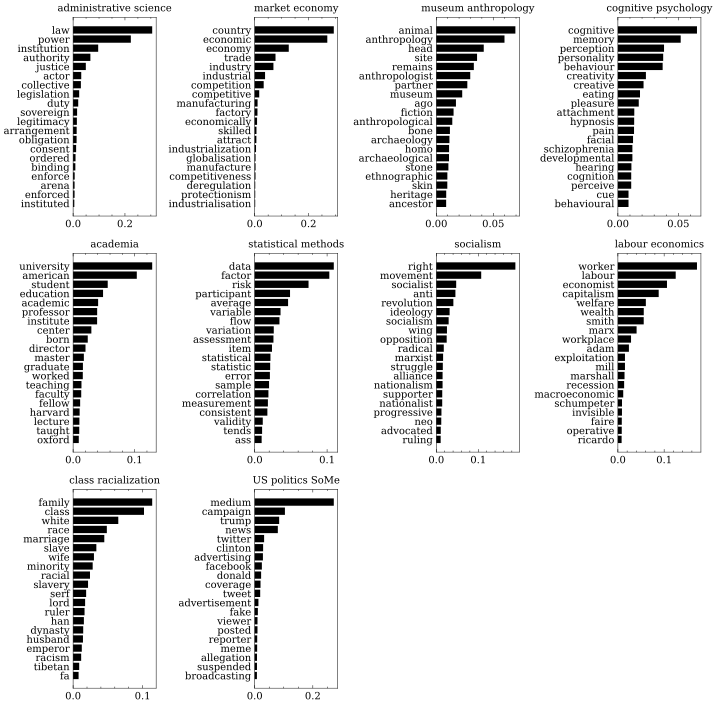

In [162]:
# Plot word probability distribution
fig, axs = plt.subplots(nrows = 3, ncols = 4,  figsize = (10,10), dpi = 300)
axs = axs.flat
fig.delaxes(axs[10])
fig.delaxes(axs[11])
for i in range(len(topic_df)):
    y = [i[0] for i in topic_df["topics"][i]][::-1]
    x = [i[1] for i in topic_df["topics"][i]][::-1]
    axs[i].barh(y, x, color = "k")
    axs[i].set_title(topic_df.index.tolist()[i].replace('_', ' '), fontsize = 10)
    axs[i].yaxis.set_ticks_position('none') 
plt.tight_layout()

From the words, we are already able to get a general idea of what kind of topic to infer. Based on our knowledge of the different disciplines, we are able to get an overall sense of whether we are dealing with an interdisciplinary topic such as 'statistical methods' or a disciplinary topic such as cognitive psychology. We do however want to be certain in our assesment and have therefore extracted the topic distribution for each chosen topic and their relation to articles in our corpus. We create clusters of the top 30 articles which are most related to each topic to better name the topics. 

In [11]:
# we create a function to extract the relevant data from our topic distributions
def get_topic_dist(key):
    
    # get the topic
    topic = topics_l1[key]
    # get the words belonging to each topic
    words = [tuple[0] for index, tuple in enumerate(topic)]
    # and their probabilities
    word_prob = [tuple[1] for index, tuple in enumerate(topic)]
    # get the 30 most probable articles related from the topic distribution
    topic_dist = topic_dist_df.iloc[key].sort_values(ascending = False)[:30]
    # store their probabilities
    article_probabilities = [t for t in topic_dist]
    # and their names
    articles = [t for t in topic_dist.index]
    
    #print('topic name: ' + str(topic))
    #print('topic words: ' + str(words))
    #print('topic distribution: ' + str(topic_dist_df.iloc[key].sort_values(ascending = False)[:30]))
    
    return topic_num_names[key], article_probabilities, articles, words, word_prob

Let's apply the function

In [12]:
# lists of the different values we need 
topics = []
probabilities = []
article_names = []
words = []
word_prob = []

# we use our topic distribution function to extract all relevant values
for key in topic_num:
    element = get_topic_dist(key)
    topics.append(element[0])
    probabilities.append(element[1])
    article_names.append(element[2])
    words.append(element[3])
    word_prob.append(element[4])

In [169]:
# let's take a look at the 20 most probable articles and words for this topic
topic0 = pd.DataFrame(list(zip(article_names[0], probabilities[0])), 
             columns = ['topic: administrative politics', 'probability'])
topic0[:20]

,topic: administrative politics,probability
0,political_science-law_without_the_state,0.225806
1,political_science-exclusive_federal_powers,0.161017
2,economics-economic_power,0.142857
3,political_science-the_province_of_jurisprudenc...,0.140000
4,political_science-concurrent_powers,0.134021
5,political_science-dualism_(law),0.133492
6,political_science-political_obligation,0.130682
7,political_science-retslægerådet,0.130435
8,sociology-authority_(sociology),0.126411
9,political_science-implied_powers,0.119617


For topic 7, we infer it to regard administrative science. While the most probable words are 'law', 'power', and 'institution', we also see how the topic is the majority contributor in an overweight of political science documents which suggest the topic to be political science-related. This topic is one of our more or less 'pure' discipline topics. Let's take a look at one of our more interdiciplinary topics: 

In [170]:
# let's take a look at the 20 most probable articlesfor this topic
topic5 = pd.DataFrame(list(zip(article_names[5], probabilities[5])), 
             columns = ['topic: statistical methods', 'probability'])
topic5[:20]

,topic: statistical methods,probability
0,political_science-total_survey_error,0.278846
1,political_science-non-sampling_error,0.271186
2,economics-kitchen_sink_regression,0.218750
3,psychology-list_of_backmasked_messages,0.200000
4,economics-analysis_of_rhythmic_variance,0.170213
5,psychology-psychological_statistics,0.166909
6,economics-cash_flow_hedge,0.166667
7,political_science-administrative_error,0.166667
8,economics-variance_risk_premium,0.161290
9,economics-correlation_trading,0.148936


Statistical methods is one of our most interdisciplinary topics as it is present in articles from all disciplines. We find in particular that articles from psychology, political science and economics are related to the topic suggesting that statistical methods is a topic of interdisciplinary character. Intuitively, this aligns with our understanding of the different disciplines as statistical inference and causality traditionally both are strived for in academic work from these fields and thus involve well-known methods related to this topic which would be written about on Wikipedia. 
    Since the distribution of wikipedia articles between disciplines is skewed towards political science, we find many political science-related topics in general as well as articles in each topic. 


## Bipartite network of 10 topics-articles

We want to visualize the topics and their related articles as well as their related words in two separate bipartite networks. The topics will be one type of nodes and the articles another type. Links represents articles connected to the given topic. The links are further weigthed by the probabilities for an article to be contributing/explanatory of the topic. 

In [22]:
# we ready the data for the network by creating lists of the topic, article name and probability
w = list()
for i in range(len(article_names)):
    for element in range(len(article_names[0])):
        w.append([topics[i], article_names[i][element],probabilities[i][element]])

In [24]:
# bipartite network x graph object of topic-articles
B=nx.Graph()
B.add_nodes_from(bipart_nx['source'], bipartite=0)
B.add_nodes_from(bipart_nx['target'], bipartite=1)
B.add_weighted_edges_from(w)

In [137]:
edge_list = [(edge.source, edge.target, edge.weight) for edge in bipart_nx.itertuples(index=False)]
node_atributes = pd.DataFrame(bipart_nx['source'].tolist() + bipart_nx['target'].tolist(), columns = ['node'])
node_atributes['category'] = node_atributes['node'].apply(lambda x: 'target' if x in bipart_nx['target'].tolist() else 'source')
node_atributes['node_attr'] = list(node_atributes.node.apply(lambda x: x.split('-')[0]))
node_atributes['node_attr'] = node_atributes['node_attr'].apply(lambda x: 'topic' if x in node_atributes['node'].tolist() else x)

In [176]:
import pickle 
node_atributes.to_pickle('node_attributes.pkl')
with open('weighted_edge_list.pkl', 'wb') as f:
    pickle.dump(edge_list, f)
    
#edge_list.to_pickle('weighted_edge_list.pkl')

# insert interactive graph of topics-articles